In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

import keras_tuner as kt



---

**CONNECT TO DRIVE**



In [ ]:
drive.mount('/content/drive')



**Get Dataset from Google Drive**


In [ ]:
train_dir = "/content/drive/My Drive/WBC_dataset/images/TRAIN"
test_dir = "/content/drive/My Drive/WBC_dataset/images/TEST"
val_dir = "/content/drive/My Drive/WBC_dataset/images/TEST_SIMPLE"

---

**Prepare Data**

In [ ]:
batch_size = 32
img_height = 240
img_width = 320

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

In [ ]:
train_list = train_ds.as_numpy_iterator()
test_list = test_ds.as_numpy_iterator()
val_list = val_ds.as_numpy_iterator()

In [ ]:
train_x = []
train_y = []

for i, element in enumerate(train_list):
  sample_list = np.random.choice(len(element[0]), int(np.ceil(0.85 * len(element[0]))))
  for index in sample_list:
    train_x.append( element[0][index] )
    train_y.append( element[1][index] )

In [ ]:
test_x = []
test_y = []

for i, element in enumerate(test_list):
  sample_list = np.random.choice(len(element[0]), int(np.ceil(0.85 * len(element[0]))))
  for index in sample_list:
    test_x.append( element[0][index] )
    test_y.append( element[1][index] )

In [ ]:
val_x = []
val_y = []

for i, element in enumerate(val_list):
  sample_list = np.random.choice(len(element[0]), int(np.ceil(0.85 * len(element[0]))))
  for index in sample_list:
    val_x.append( element[0][index] )
    val_y.append( element[1][index] )

In [ ]:
X_train = np.array(train_x)
y_train = np.array(train_y)

X_test = np.array(test_x)
y_test = np.array(test_y)

X_val = np.array(val_x)
y_val = np.array(val_y)

In [ ]:
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
y_val = np.reshape(y_val, (-1, 1))

In [ ]:
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")
print(f"x_test shape: {X_val.shape} - y_test shape: {y_val.shape}")



---
**Hyperparameters**


In [ ]:
input_shape = [240, 320, 3]
learning_rate = 0.001
weight_decay = 0.001
batch_size = 256
num_classes = 4
num_epochs = 100
image_size= 720
patch_size = 60
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 12
mlp_head_units = [2048, 1024]



---
**Data Augmentation**


In [ ]:
augmentation_layer = keras.Sequential(
  [
      layers.Input(input_shape),
      layers.Normalization(),
      layers.Resizing(image_size, image_size),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(factor=0.02),
      layers.RandomZoom(height_factor=0.2, width_factor=0.2),
  ],
  name="augmentation_layer",
)

augmentation_layer.layers[0].adapt(X_train)



---
**Multilayer Perceptron**


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



---

**Patch as layer**

In [ ]:
@keras.saving.register_keras_serializable(package="MyLayers", name="Patches")
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

(240, 320, 3)
(1, 720, 720, 3)
Image size: 720 X 720
Patch size: 60 X 60
Patches per image: 144
Elements per patch: 10800


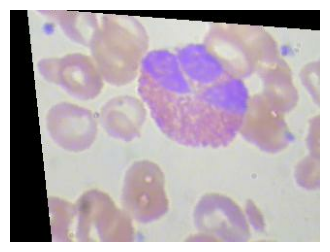

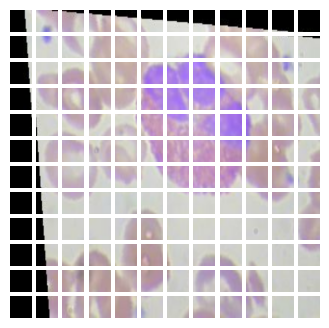

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
@keras.saving.register_keras_serializable(package="MyLayers", name="PatchEncoder")
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(patch_size)(augmented)
    encoder_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1
        )(x1, x1)
        
        x2 = layers.Add()([attention_output, encoder_patches])
        
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        encoder_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation,
                   hidden_units=mlp_head_units,
                   dropout_rate=0.5)

    outputs = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 augmentation_layer (Sequen  (None, 720, 720, 3)          7         ['input_2[0][0]']             
 tial)                                                                                            
                                                                                                  
 patches_1 (Patches)         (None, None, 10800)          0         ['augmentation_layer[0][0]']  
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 128)             1400960   ['patches_1[0][0]']       

In [ ]:
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)

checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

history = vit_classifier.fit(
  X_train,
  y_train,
  epochs=num_epochs,
  batch_size=batch_size,
  validation_data=(X_test, y_test),
  callbacks=[checkpoint]
)

Epoch 1/100
28/28 [==============================] - 61s 695ms/step - loss: 100.4807 - accuracy: 0.2518 - val_loss: 1.3858 - val_accuracy: 0.2588
Epoch 2/100
28/28 [==============================] - 15s 552ms/step - loss: 1.4446 - accuracy: 0.2440 - val_loss: 1.3862 - val_accuracy: 0.2588
Epoch 3/100
28/28 [==============================] - 16s 576ms/step - loss: 1.4077 - accuracy: 0.2466 - val_loss: 1.3865 - val_accuracy: 0.2588
Epoch 4/100
28/28 [==============================] - 17s 612ms/step - loss: 1.3996 - accuracy: 0.2512 - val_loss: 1.3869 - val_accuracy: 0.2312
Epoch 5/100
28/28 [==============================] - 17s 615ms/step - loss: 1.3994 - accuracy: 0.2542 - val_loss: 1.3874 - val_accuracy: 0.2312
Epoch 6/100
28/28 [==============================] - 17s 612ms/step - loss: 1.4090 - accuracy: 0.2549 - val_loss: 1.3909 - val_accuracy: 0.2312
Epoch 7/100
28/28 [==============================] - 16s 580ms/step - loss: 3.4294 - accuracy: 0.2519 - val_loss: 1.3869 - val_accurac